# **Breast Cancer Detection, A Data Science Project with PySpark**

A study to predict diagnose breast cancer, using the machine learning methods from the features created by digitizing the images of breast cancer.




## **Table of Content**

[Purpose](#purpose)   
[Dependencies and Libraries](#dependencies_and_libraries)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[1. Without Feature Selection](#withoutfeatureselection)    
> [a. Modeling for Clustering](#a1clusteringmodel)  
> [b. Clustering results](#b1clustering)    

[2. With Feature Selection](#withfeatureselection) 
> [a. Correlation with Diagnosis](#CorrelationwithDiagnosis)  
>> [1. Modeling for Clustering](#a2clusteringmodel)   
>> [2. Clustering results](#b2clustering) 
 
> [b. Correlation with Each Other](#CorrelationwithEachOther)  
>> [1. Modeling for Clustering](#a3clusteringmodel)   
>> [2. Clustering results](#b3clustering) 

[Modeling for Random Forest Classification](#rfclassificationmodel)  
[Evaluation for Random Forest Classification](#rfevaluation) 


[References](#references)   

## **Purpose** <a class="anchor" id="purpose"></a>

In this project, our purpose is to diagnose breast cancer with using the data which are created by digitizing breast cancer images. To be able to predict the diagnosis we used several machine learning methods. These are K-means clustering, Random Forest Algorithm and K-Nearest Neighbors Algorithm. 

## **Dependencies and Libraries**  <a class="anchor" id="dependencies_and_libraries"></a>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

Dependencies are installed.



In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

The location of Java and Spark has been set.

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Installation is tested.

In [4]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from pyspark.sql.functions import when
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, trim, lower
from pyspark.sql import functions as f
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import RandomForest
from time import *


%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Necessary libraries are added.


In [0]:
sc =SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

sqlContext is created.

## **Data Understanding**<a class="anchor" id="data_understanding"></a>

In [0]:
path = '/content/data.csv'
OD = sqlContext.read.csv(path, header=True)

#OD_pd = pd.read_csv("data.csv") # for checking with pandas
#OD.show()

In [7]:
OD.printSchema()

root
 |-- id: string (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: string (nullable = true)
 |-- texture_mean: string (nullable = true)
 |-- perimeter_mean: string (nullable = true)
 |-- area_mean: string (nullable = true)
 |-- smoothness_mean: string (nullable = true)
 |-- compactness_mean: string (nullable = true)
 |-- concavity_mean: string (nullable = true)
 |-- concave points_mean: string (nullable = true)
 |-- symmetry_mean: string (nullable = true)
 |-- fractal_dimension_mean: string (nullable = true)
 |-- radius_se: string (nullable = true)
 |-- texture_se: string (nullable = true)
 |-- perimeter_se: string (nullable = true)
 |-- area_se: string (nullable = true)
 |-- smoothness_se: string (nullable = true)
 |-- compactness_se: string (nullable = true)
 |-- concavity_se: string (nullable = true)
 |-- concave points_se: string (nullable = true)
 |-- symmetry_se: string (nullable = true)
 |-- fractal_dimension_se: string (nullable = true)
 |-- radiu

As we can see, the data types of the columns are string. We should convert these to float data type.

In [0]:
#OD.describe().show()

This table shows us the summary statistics of columns in the Original DataFrame. So we can see that column c_32 is full of NaN values and column diagnosis has not float numbers.

## **Data Preparation**<a class="anchor" id="data_preparation"></a>

In [0]:
columns_to_drop = ['_c32', 'id']
OD = OD.drop(*columns_to_drop)

#OD.printSchema()

The first column contains credentials that do not contribute to guessing. Therefore, we must leave the identity columns. The last column is filled with NaN values. So these should also be lowered.

> The most important reason for removing the columns that will not contribute to the results from our dataframe is that the speed of the model we designed will increase.

Converting the data types of the columns from string to float.


In [0]:
for col in OD.columns:
  if col != 'diagnosis':
    OD = OD.withColumn(col,OD[col].cast('float'))

#OD.show()

Replace the diagnosis symbols at Original Data. 1 for malignant, 0 for benign.

In [0]:
OD = OD.withColumn("diagnosis", when(OD["diagnosis"] == 'M', 1).otherwise(0))
#OD.show()

Columns list without 'diagnosis' columnn.

In [0]:
feature_columns = ["radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean",
           "concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se",
           "texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se",
           "concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst",
           "perimeter_worst","area_worst","smoothness_worst","compactness_worst",
           "concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst"]
           
feature_columns_with_dia = ["diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean",
           "concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se",
           "texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se",
           "concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst",
           "perimeter_worst","area_worst","smoothness_worst","compactness_worst",
           "concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst"]

### **Normalization**

Implementation of The Min-Max Normalization. The dataset of Normalization result of original data is ND.

Preparation a copy of Original Dataset to use in normalization part and "diagnosis" column shouldn't be in the data while we are normalizing the data.

In [0]:
_schema = copy.deepcopy(OD.schema)
ND1 = OD.rdd.zipWithIndex().toDF(_schema)

columns_to_scale = feature_columns_with_dia
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(OD)
ND1 = scalerModel.transform(OD)

names = {x + "_scaled": x for x in columns_to_scale}
ND1 = ND1.select([f.col(c).alias(names[c]) for c in names.keys()])

OD_pd = OD.toPandas()
ND_pd = ND1.toPandas()

def explode_(x):
    return x[0]
ND_pd = ND_pd.applymap(explode_)
ND = spark.createDataFrame(ND_pd)

#OD.show()
#ND.show()

### **Correlation**

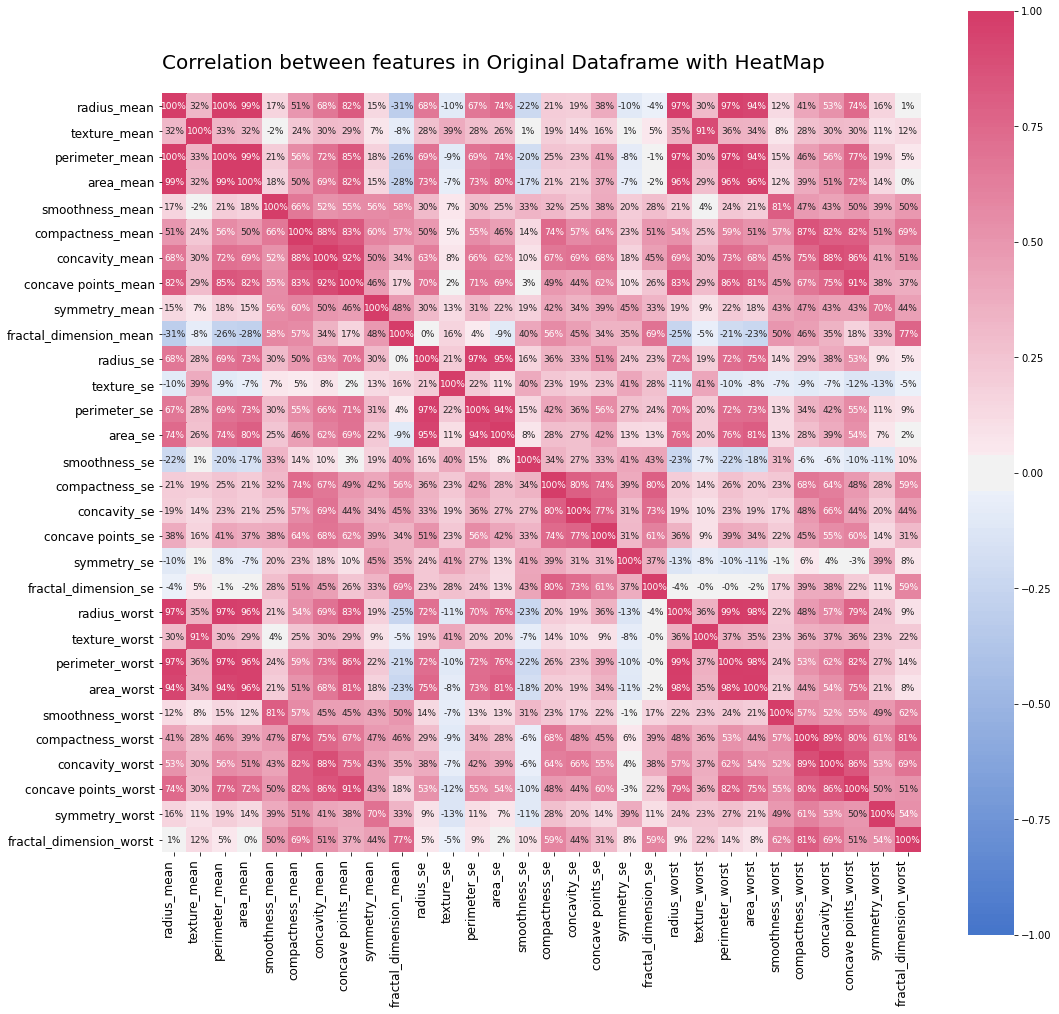

In [14]:
from pyspark.ml.stat import Correlation

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=feature_columns, outputCol=vector_col)
myGraph_vector = assembler.transform(OD).select(vector_col)
matrix = Correlation.corr(myGraph_vector, vector_col)

matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
#print(corrmatrix)
df = spark.createDataFrame(corrmatrix,feature_columns)
#df.show()

def plot_corr_matrix(correlations,attr,fig_no):

  fig=plt.figure(fig_no,figsize=(17,17))
  ax=fig.add_subplot(111)
  sns.heatmap(correlations, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(255, 0, n=200), annot=True, fmt=".0%", annot_kws={"size": 9}, square=True, ax = ax)
  plt.yticks(rotation=0) 
  ax.set_yticklabels(feature_columns, fontsize = 12 );
  ax.set_xticklabels(feature_columns,rotation=90,horizontalalignment='right', fontsize = 12 );


  
  plt.text(0,-1, "Correlation between features in Original Dataframe with HeatMap", fontsize = 20, color='Black')
  plt.show()

plot_corr_matrix(corrmatrix, feature_columns, 234)

To be able to see the correlations between the features, heatmap from seaborn is used.

> If we look at the plot, we see the darker pinks in between highly correlated columns. Highly correlated columns says us that one of these columns can be dropped from dataframe if we want to decrease the size of the dataframe. Lets create a new dataframe that hasn't got any columns which has the correlation between 97% and 100% and -97% and -100% with another feature.



In [0]:
columns_to_drop = ['perimeter_mean','area_mean','radius_worst','perimeter_worst','perimeter_se','area_worst']
OD_fs = OD.drop(*columns_to_drop)
ND_fs = ND.drop(*columns_to_drop)

columns_list_with_feature_selection = ["diagnosis","radius_mean","texture_mean","smoothness_mean","compactness_mean",
                                    "concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se",
                                    "texture_se","area_se","smoothness_se","compactness_se","concavity_se",
                                    "concave points_se","symmetry_se","fractal_dimension_se","texture_worst",
                                    "smoothness_worst","compactness_worst",
                                    "concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst"]

To be able to see the correlation between the features and diagnosis we can draw a bar plot.

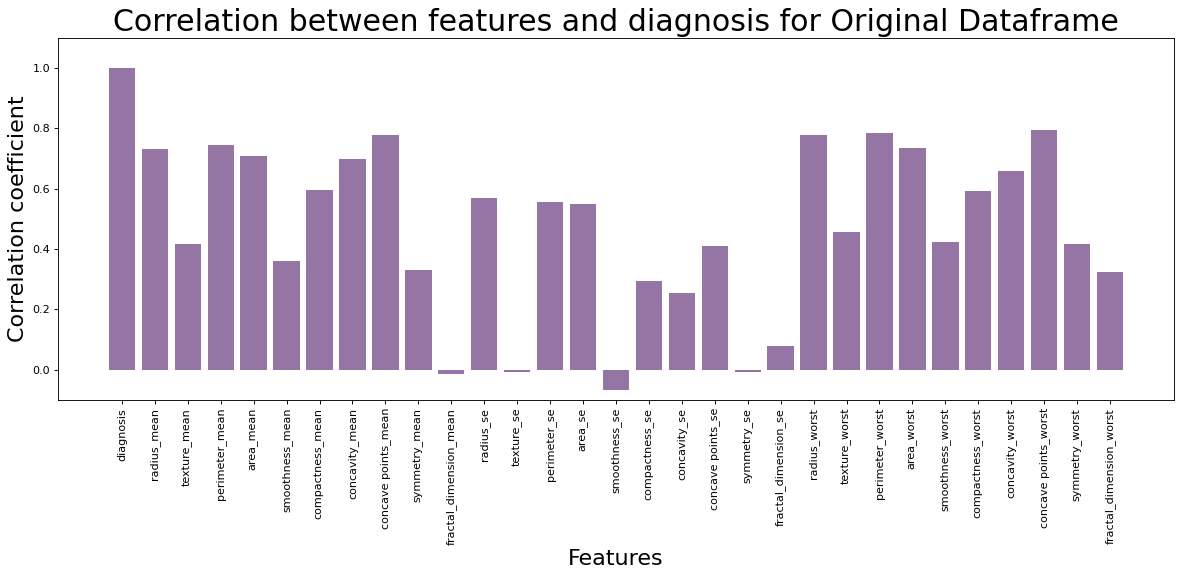

In [16]:
def correlation_diagnosis(df, color):
  corr_OD_fig = plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
  corr_OD = corr_OD_fig.add_subplot(111)
  correlations_OD =[]

  for column in df.columns:
      # print('Correlation between '+ column + ' and ' + 'diagnosis : ', np.corrcoef(np.array(OD[column]), np.array(OD['diagnosis']))[0][1])
      correlations_OD.append(np.corrcoef(np.array(df[column]), np.array(df['diagnosis']))[0][1])

  plt.bar(list(df.columns) ,  correlations_OD, color = color)       

  plt.title('Correlation between features and diagnosis for Original Dataframe',fontsize=27)
  plt.xlabel('Features',fontsize=20)
  plt.ylabel('Correlation coefficient',fontsize=20)    

  plt.ylim(-0.1,1.1)
  plt.xticks(rotation=90)
  plt.show()

correlation_diagnosis(OD_pd, (0.3,0.1,0.4,0.6))


It is showed the relationship between features and diagnosis to find out which feature is more effective for finding the diagnosis.

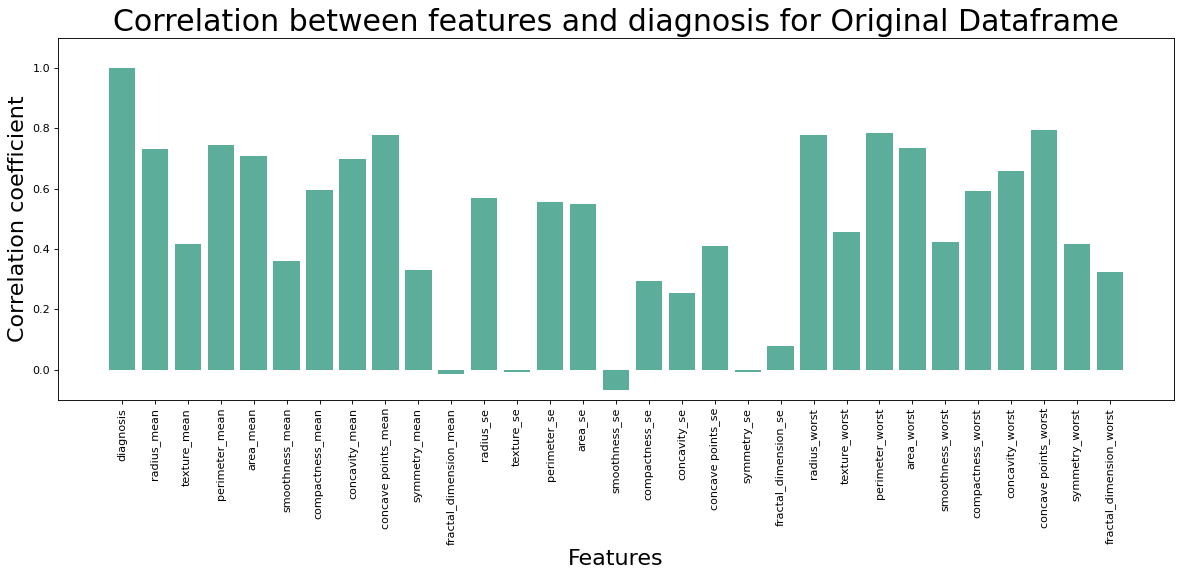

In [17]:
correlation_diagnosis(ND_pd, (0.2,0.6,0.5,0.8))

By looking at these two graphs, it was determined that the min-max normalization of the original data did not affect the correlation between the features and diagnosis.

We eliminate the features that is under the 0.2 correlation limit for both dataframes.

In [0]:
columns_to_drop = ['fractal_dimension_mean','texture_se','smoothness_se','symmetry_se','fractal_dimension_se']
OD_fs1 = OD.drop(*columns_to_drop)
ND_fs1 = ND.drop(*columns_to_drop)

columns_list_with_feature_selection1 = ["radius_mean","texture_mean","perimeter_mean",
                                      "area_mean","smoothness_mean","compactness_mean",
                                      "concavity_mean","concave points_mean","symmetry_mean","radius_se",
                                      "perimeter_se","area_se","compactness_se","concavity_se",
                                      "concave points_se","radius_worst","texture_worst",
                                      "perimeter_worst","area_worst","smoothness_worst","compactness_worst",
                                      "concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst"]



## **1. Without Feature Selection**  <a class="anchor" id="withoutfeatureselection"></a>


### **a. Modeling for Clustering** <a class="anchor" id="a1clusteringmodel"></a> 

For clustering, we need to store all features as an array of floats, and store this array as a column called "features". Since we do no longer need the original columns we filter them out with a select statement.

In [0]:
vecAssemblerOD = VectorAssembler(inputCols=feature_columns, outputCol="features")
OD_kmeans = vecAssemblerOD.transform(OD).select('diagnosis', 'features')
#OD_kmeans.show()

vecAssemblerND = VectorAssembler(inputCols=feature_columns, outputCol="features")
ND_kmeans = vecAssemblerND.transform(ND).select('diagnosis', 'features')
#ND_kmeans.show()

K-means Clustering on Original DataFrame.

In [0]:
k = 2
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model_OD = kmeans.fit(OD_kmeans)
centers_OD = model_OD.clusterCenters()


K-means Clustering on Normalized DataFrame.

In [0]:
k = 2
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model_ND = kmeans.fit(ND_kmeans)
centers_ND = model_ND.clusterCenters()


### **b. Clustering results**<a class="anchor" id="b1clustering"></a>

After finding centers we should assign the each row to the nearest cluster center. That can be done with the transform method, which adds 'prediction' column to the dataframe. The prediction value is an integer between 0 and 1, but it has no correlation to the y value of the input.

In [0]:
transformed_OD = model_OD.transform(OD_kmeans).select('diagnosis', 'prediction')
rows_OD = transformed_OD.collect()
#print(rows_OD[:2])

transformed_ND = model_ND.transform(ND_kmeans).select('diagnosis', 'prediction')
rows_ND = transformed_ND.collect()
#print(rows_ND[:2])

In [0]:
OD_pred = sqlContext.createDataFrame(rows_OD)
#OD_pred.show()

ND_pred = sqlContext.createDataFrame(rows_ND)
#ND_pred.show()

In [0]:
OD_pred_all = OD_pred.join(OD, 'diagnosis')
#OD_pred_all.show()

ND_pred_all = ND_pred.join(ND, 'diagnosis')
#ND_pred_all.show()

In [0]:
def accuracy(df):
  TP = 0
  FP = 0
  FN = 0
  TN = 0 

  for row in df.rdd.collect():
    if row["diagnosis"] == 1 and  row["prediction"] == 1:
      TN = TN + 1 
    elif row["diagnosis"] == 1 and  row["prediction"] == 0:
      FP = FP + 1 
    elif row["diagnosis"] == 0 and  row["prediction"] == 1:
      FN = FN + 1 
    elif row["diagnosis"] == 0 and  row["prediction"] == 0:
      TP = TP + 1 

  if TP+TN < FP+FN:
    swapT = TP
    swapF = FP
    TP = FN
    FP = TN
    FN = swapT
    TN = swapF

  confusion_matrix=[[TP,FP],[FN,TN]]

  figure = plt.figure(figsize = (10,7))
  ax = figure.add_subplot(111)
  sns.set(font_scale = 1.4)
  sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 20}, fmt="d", linewidths=.5, cmap="OrRd")
  plt.title('Confusion Matrix of The Classified Dataframe\n', size = 25)

  ax.set_yticklabels(["Real Benign","Real Malignant"], fontsize = 12 );
  ax.set_xticklabels(["Predicted Benign", "Predicted Malignant"], fontsize = 12 );

  accuracy = ((TP+TN)/(TP+FP+FN+TN))*100
  precision = (TP/(TP+FP))*100
  recall = (TP/(TP+FN))*100
  f1Score = 2*(recall * precision) / (recall + precision)

  print("\n\t Accuracy : "+ "%" + "%5.2f " %accuracy)
  print("\t Precision : "+ "%" + "%5.2f " %precision)
  print("\t Recall : "+ "%" + "%5.2f " %recall)
  print("\t F1 Score : "+ "%" + "%5.2f \n\n" %f1Score)

  plt.show()
  return [accuracy,precision,recall,f1Score]


	 Accuracy : %85.41 
	 Precision : %81.28 
	 Recall : %99.72 
	 F1 Score : %89.56 




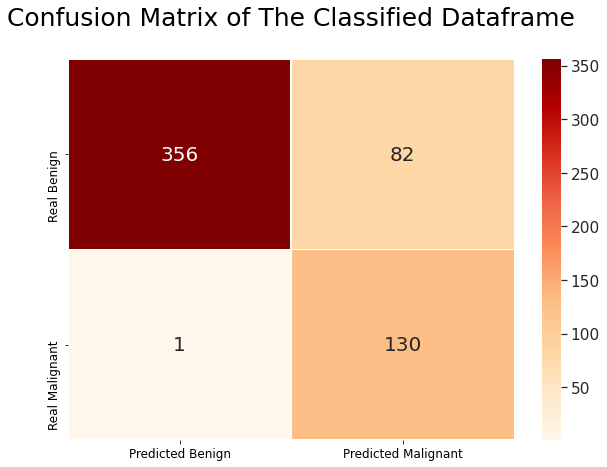

In [26]:
temp = accuracy(OD_pred)
with_accuracy_OD = temp[0] 
with_precision_OD = temp[1]
with_recall_OD = temp[2]
with_f1Score_OD = temp[3]


	 Accuracy : %92.79 
	 Precision : %91.58 
	 Recall : %97.48 
	 F1 Score : %94.44 




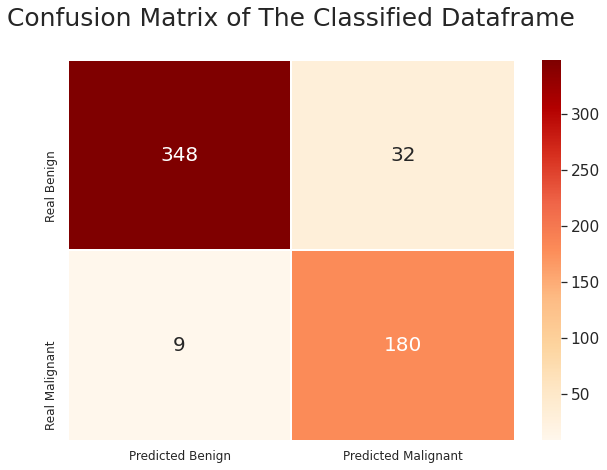

In [27]:
temp = accuracy(ND_pred)
with_accuracy_ND = temp[0] 
with_precision_ND = temp[1]
with_recall_ND = temp[2]
with_f1Score_ND = temp[3]

With these operations, we see that the accuracy value that is the result of the k-means classification algorithm is higher in the Normalized Dataframe than Original Dataframe.

    

## **2. With Feature Selection** <a class="anchor" id="withfeatureselection"></a>


## **a. Correlation with Diagnosis** <a class="anchor" id="CorrelationwithDiagnosis"></a>

### **1. Modeling for Clustering** <a class="anchor" id="a2clusteringmodel"></a> 

For clustering, we need to store all features as an array of floats, and store this array as a column called "features". Since we do no longer need the original columns we filter them out with a select statement.

In [0]:
vecAssemblerOD_fs1 = VectorAssembler(inputCols=columns_list_with_feature_selection1, outputCol="features")
OD_fs1_kmeans = vecAssemblerOD_fs1.transform(OD_fs1).select('diagnosis', 'features')
#OD_fs1_kmeans.show()

vecAssemblerND_fs1 = VectorAssembler(inputCols=columns_list_with_feature_selection1, outputCol="features")
ND_fs1_kmeans = vecAssemblerND_fs1.transform(ND_fs1).select('diagnosis', 'features')
#ND_fs1_kmeans.show()

K-means Clustering on Original DataFrame.

In [0]:
k = 2
kmeans_fs1 = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model_OD_fs1 = kmeans.fit(OD_fs1_kmeans)
centers_OD_fs1 = model_OD_fs1.clusterCenters()


K-means Clustering on Normalized DataFrame.

In [0]:
k = 2
kmeans_fs1 = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model_ND_fs1 = kmeans.fit(ND_fs1_kmeans)
centers_ND_fs1 = model_ND_fs1.clusterCenters()

### **2. Clustering results**<a class="anchor" id="b2clustering"></a>

After finding centers we should assign the each row to the nearest cluster center. That can be done with the transform method, which adds 'prediction' column to the dataframe. The prediction value is an integer between 0 and 1, but it has no correlation to the y value of the input.

In [0]:
transformed_OD_fs1 = model_OD_fs1.transform(OD_fs1_kmeans).select('diagnosis', 'prediction')
rows_OD_fs1 = transformed_OD_fs1.collect()
#print(rows_OD[:2])

transformed_ND_fs1 = model_ND_fs1.transform(ND_fs1_kmeans).select('diagnosis', 'prediction')
rows_ND_fs1 = transformed_ND_fs1.collect()
#print(rows_ND[:2])

In [0]:
OD_pred_fs1 = sqlContext.createDataFrame(rows_OD_fs1)
#OD_pred_fs1.show()

ND_pred_fs1 = sqlContext.createDataFrame(rows_ND_fs1)
#ND_pred_fs1.show()

In [0]:
OD_pred_all_fs1 = OD_pred_fs1.join(OD, 'diagnosis')
#OD_pred_all_fs1.show()

ND_pred_all_fs1 = ND_pred_fs1.join(ND, 'diagnosis')
#ND_pred_all_fs1.show()


	 Accuracy : %85.41 
	 Precision : %81.28 
	 Recall : %99.72 
	 F1 Score : %89.56 




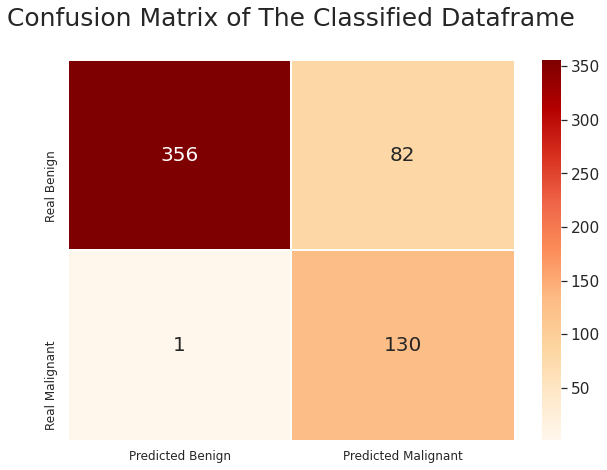

In [34]:
temp = accuracy(OD_pred_fs1)
with_accuracy_OD_fs1 = temp[0] 
with_precision_OD_fs1 = temp[1]
with_recall_OD_fs1 = temp[2]
with_f1Score_OD_fs1 = temp[3]


	 Accuracy : %93.32 
	 Precision : %91.64 
	 Recall : %98.32 
	 F1 Score : %94.86 




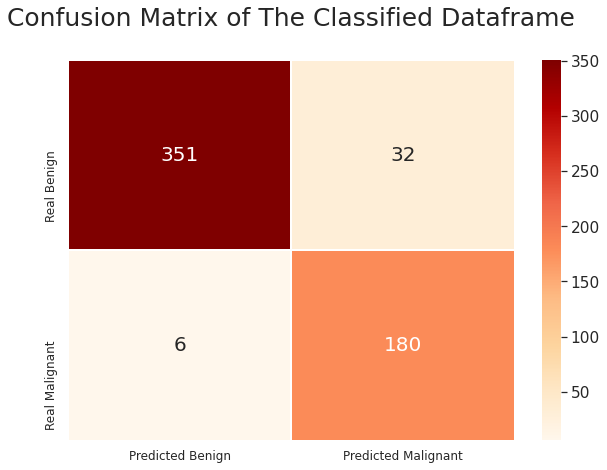

In [35]:
accuracy(ND_pred_fs1)
with_accuracy_ND_fs1 = temp[0] 
with_precision_ND_fs1 = temp[1]
with_recall_ND_fs1 = temp[2]
with_f1Score_ND_fs1 = temp[3]

With these operations, we see that the accuracy value that is the result of the k-means classification algorithm is higher in the Normalized Dataframe than Original Dataframe.

## **b. Correlation with Each Other**<a class="anchor" id="CorrelationwithEachOther"></a>


With these operations, we see that the accuracy value that is the result of the k-means classification algorithm is higher in the Normalized Dataframe than Original Dataframe.

### **1. Modeling for Clustering** <a class="anchor" id="a3clusteringmodel"></a> 

For clustering, we need to store all features as an array of floats, and store this array as a column called "features". Since we do no longer need the original columns we filter them out with a select statement.

In [0]:
vecAssemblerOD_fs = VectorAssembler(inputCols=columns_list_with_feature_selection, outputCol="features")
OD_fs_kmeans = vecAssemblerOD_fs.transform(OD_fs).select('diagnosis', 'features')
#OD_fs_kmeans.show()

vecAssemblerND_fs = VectorAssembler(inputCols=columns_list_with_feature_selection, outputCol="features")
ND_fs_kmeans = vecAssemblerND_fs.transform(ND_fs).select('diagnosis', 'features')
#ND_fs1_kmeans.show()

K-means Clustering on Original DataFrame.

In [0]:
k = 2
kmeans_fs = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model_OD_fs = kmeans.fit(OD_fs_kmeans)
centers_OD_fs = model_OD_fs.clusterCenters()


K-means Clustering on Normalized DataFrame.

In [0]:
k = 2
kmeans_fs = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model_ND_fs = kmeans.fit(ND_fs_kmeans)
centers_ND_fs = model_ND_fs.clusterCenters()

### **2. Clustering results**<a class="anchor" id="b3clustering"></a>

In [0]:
transformed_OD_fs = model_OD_fs.transform(OD_fs_kmeans).select('diagnosis', 'prediction')
rows_OD_fs = transformed_OD_fs.collect()
#print(rows_OD[:2])

transformed_ND_fs = model_ND_fs.transform(ND_fs_kmeans).select('diagnosis', 'prediction')
rows_ND_fs = transformed_ND_fs.collect()
#print(rows_ND[:2])

In [0]:
OD_pred_fs = sqlContext.createDataFrame(rows_OD_fs)
#OD_pred_fs1.show()

ND_pred_fs = sqlContext.createDataFrame(rows_ND_fs)
#ND_pred_fs1.show()

In [0]:
OD_pred_all_fs = OD_pred_fs.join(OD, 'diagnosis')
#OD_pred_all_fs1.show()

ND_pred_all_fs = ND_pred_fs.join(ND, 'diagnosis')
#ND_pred_all_fs1.show()


	 Accuracy : %63.09 
	 Precision : %62.96 
	 Recall : %100.00 
	 F1 Score : %77.27 




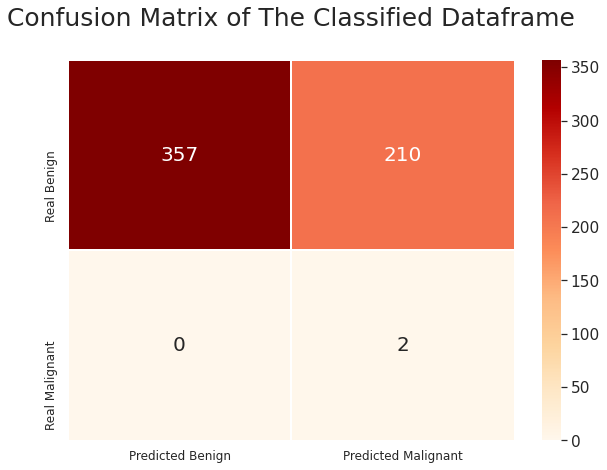

In [42]:
temp = accuracy(OD_pred_fs)
with_accuracy_OD_fs = temp[0] 
with_precision_OD_fs = temp[1]
with_recall_OD_fs = temp[2]
with_f1Score_OD_fs = temp[3]


	 Accuracy : %99.65 
	 Precision : %100.00 
	 Recall : %99.44 
	 F1 Score : %99.72 




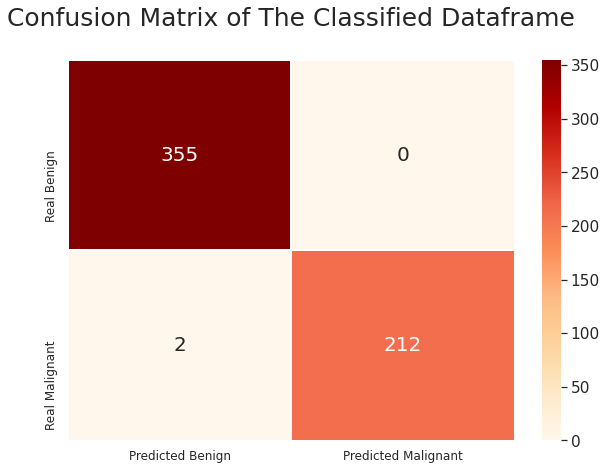

In [43]:
accuracy(ND_pred_fs)
with_accuracy_ND_fs = temp[0] 
with_precision_ND_fs = temp[1]
with_recall_ND_fs = temp[2]
with_f1Score_ND_fs = temp[3]

With these operations, we see that the accuracy value that is the result of the k-means classification algorithm is higher in the Normalized Dataframe than Original Dataframe.

### **Visualization of Clustering**

Visualization function is below.

In [0]:
from sklearn.cluster import KMeans

def visualize_clustering(x,y):
  pca=PCA(n_components=2,random_state=42)

  pca.fit(x)

  x_pca=pca.transform(x)

  plt.figure()
  plt.figure(figsize=(10,10))
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=14)
  plt.xlabel('Principal Component - 1',fontsize=20)
  plt.ylabel('Principal Component - 2',fontsize=20)
  plt.title("Principal Component Analysis of The Dataset",fontsize=20)

  x_train_pca,x_test_pca,y_train_pca,y_test_pca=train_test_split(x_pca,y,test_size=.3,random_state=42)

  km = KMeans(n_clusters=2)
  km.fit(x_train_pca)
  y_pred=km.predict(x_train_pca)
  ac = accuracy_score(y_train_pca,y_pred)

  plt.scatter(x_train_pca[:,0],x_train_pca[:,1],c=y_pred,s=50,cmap='cividis')
  centers=km.cluster_centers_
  plt.scatter(centers[:,0],centers[:,0],c='r',s=200,alpha=0.5)

  plt.show()

For k-means clustering visualization of The Original Dataframe.

<Figure size 432x288 with 0 Axes>

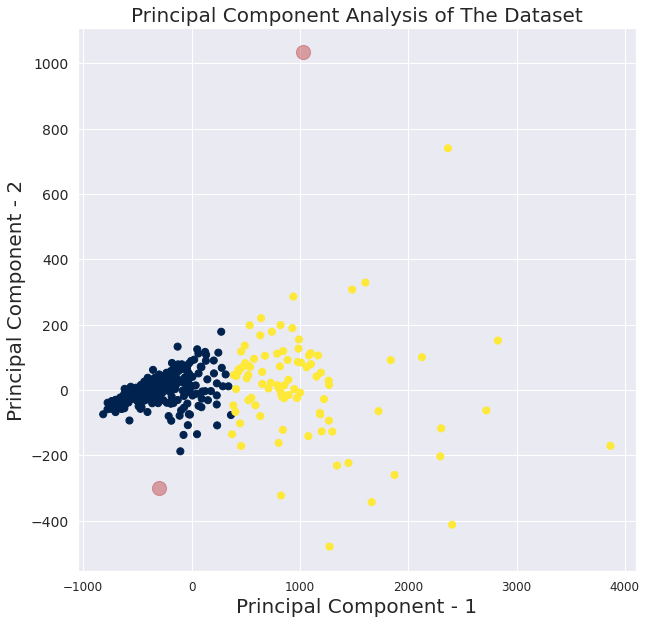

In [45]:
x = OD_pd.drop("diagnosis",axis=1)
y = OD_pd["diagnosis"]

visualize_clustering(x,y)

For k-means clustering visualization of The Normalized Dataframe.

<Figure size 432x288 with 0 Axes>

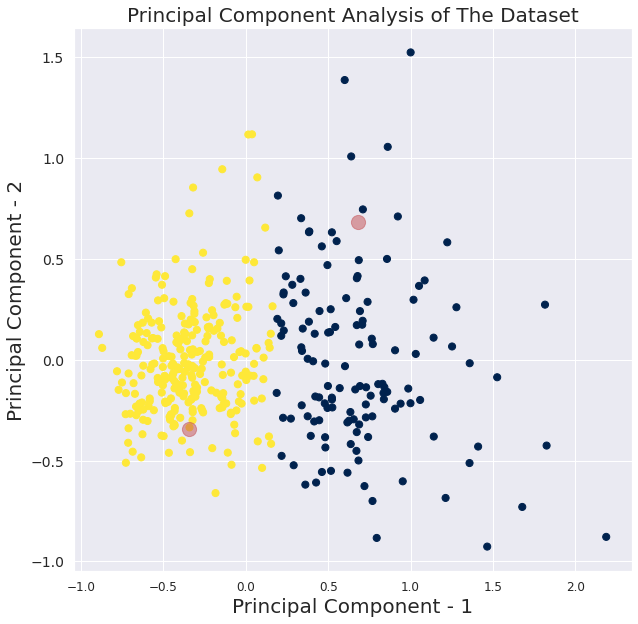

In [46]:
x = ND_pd.drop("diagnosis",axis=1)
y = ND_pd["diagnosis"]

visualize_clustering(x,y)

## **Modeling for Random Forest Classification** <a class="anchor" id="rfclassificationmodel"></a>

First of all, we put the diagnosis column at the end of the dataframes. 

In [0]:
temp = OD_pd["diagnosis"]
OD_pd = OD_pd.iloc[:,1:]
OD_pd["diagnosis"]=temp

OD = spark.createDataFrame(OD_pd)

temp = ND_pd["diagnosis"]
ND_pd = ND_pd.iloc[:,1:]
ND_pd["diagnosis"]=temp

ND = spark.createDataFrame(ND_pd)

User defined Random Forest Clasification modelling function.

In [0]:
def RandomForestModelling(df):
  transformed_df = df.rdd.map(lambda row: LabeledPoint(row[-1], Vectors.dense(row[0:-1])))

  splits = [0.7, 0.3]
  training_data, test_data = transformed_df.randomSplit(splits, 13579)

  print("Number of training set rows: %d" % training_data.count())
  print("Number of test set rows: %d" % test_data.count())

  start_time = time()

  model = RandomForest.trainClassifier(training_data, numClasses=2, categoricalFeaturesInfo={}, \
      numTrees=3, featureSubsetStrategy="auto", impurity="gini", \
      maxDepth=4, maxBins=32, seed=13579)

  end_time = time()
  elapsed_time = end_time - start_time
  print("Time to train model: %.3f seconds" % elapsed_time)

  return [test_data,model]

Implementation of Random Forest Algorithm as classification to Original Dataframe.



In [49]:
OD_prediction_parameters = RandomForestModelling(OD)

Number of training set rows: 391
Number of test set rows: 178
Time to train model: 1.277 seconds


Implementation of Random Forest Algorithm as classification to Normalized Dataframe.

In [50]:
ND_prediction_parameters = RandomForestModelling(ND)

Number of training set rows: 391
Number of test set rows: 178
Time to train model: 2.195 seconds


In [0]:
#OD.show()
#ND.show()

## **Evaluation for Random Forest Classification**<a class="anchor" id="rfevaluation"></a>

User defined function that predicts and calculates accuracy of Random Forest model.


In [0]:
def predict_acc(list):
  test_data = list[0]
  model = list[1]
  predictions = model.predict(test_data.map(lambda x: x.features))
  labels_and_predictions = test_data.map(lambda x: x.label).zip(predictions)
  acc = labels_and_predictions.filter(lambda x: x[0] == x[1]).count() / float(test_data.count())

  TP = labels_and_predictions.filter(lambda x: x[0] == 0 and x[1] == 0).count()
  FP = labels_and_predictions.filter(lambda x: x[0] == 1 and x[1] == 0).count()
  FN = labels_and_predictions.filter(lambda x: x[0] == 0 and x[1] == 1).count()
  TN = labels_and_predictions.filter(lambda x: x[0] == 1 and x[1] == 1).count()
  
  confusion_matrix=[[TP,FP],[FN,TN]]

  figure = plt.figure(figsize = (10,7))
  ax = figure.add_subplot(111)
  sns.set(font_scale = 1.4)
  sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 20}, fmt="d", linewidths=.5, cmap="GnBu")
  plt.title('Confusion Matrix of classified Normalized Dataframe\n', size = 25)

  labels_and_predictions = labels_and_predictions.toDF().toPandas()

  ax.set_yticklabels(["Real Benign","Real Malignant"], fontsize = 12 );
  ax.set_xticklabels(["Predicted Benign", "Predicted Malignant"], fontsize = 12 );

  print("Model accuracy: %.3f%%\n" % (acc * 100))
  print(classification_report(labels_and_predictions["_1"],labels_and_predictions["_2"]))

  plt.show()

Evaluation of the accuracy result of predictions in Original Dataframe.

Model accuracy: 92.135%

              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       107
         1.0       0.90      0.90      0.90        71

    accuracy                           0.92       178
   macro avg       0.92      0.92      0.92       178
weighted avg       0.92      0.92      0.92       178



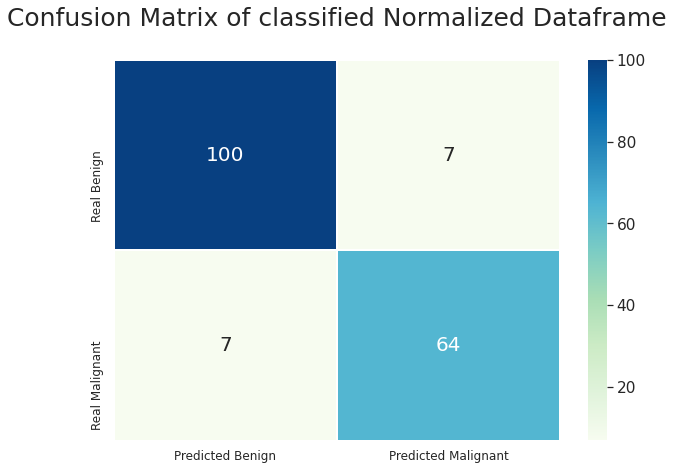

In [53]:
predict_acc(OD_prediction_parameters)

Evaluation of the accuracy result of predictions in Normalized Dataframe.


Model accuracy: 92.135%

              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       107
         1.0       0.90      0.90      0.90        71

    accuracy                           0.92       178
   macro avg       0.92      0.92      0.92       178
weighted avg       0.92      0.92      0.92       178



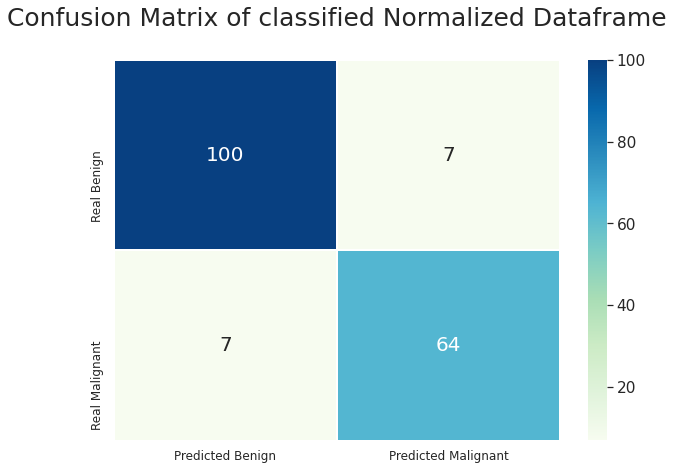

In [54]:
predict_acc(ND_prediction_parameters)

By looking at the confusion matrix obtained as a result of the classification process, it is seen that the normalized data gives the same results with the Random Forest Algorithm.


## References<a class="anchor" id="references"></a>

https://stackoverflow.com/questions/52214404/how-to-get-the-correlation-matrix-of-a-pyspark-data-frame

https://jarrettmeyer.com/2017/05/04/random-forests-with-pyspark

**Disclaimer!** <font color='grey'>This notebook was prepared by Gizem Kaya as an assigment for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>